*Note: The links in the figures don't open to a new tab. Instead you need to middle-click them to open them. Otherwise they'll just crash the GitHub notebook previewer.*

*Disclaimer: For a better viewing experience, go to [nbviewer](https://nbviewer.org/github/jackiec1998/resilient-communities/blob/main/src/notebooks/analysis.ipynb). The links below don't work on GitHub. nbviewer doesn't update immediately, so it might take a while.*

<a id="top"></a>
[r/all Analysis](#all)

[r/popular Analysis](#popular)

[Pushshift Analysis](#pushshift)

In [1]:
%config Completer.use_jedi = False
from pymongo import MongoClient
import pandas as pd
import datetime as dt
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_snapshots = client.resilient.popular
ps_comments = client.pushshift_comments
ps_threads = client.pushshift_threads

---
# Utility Functions

In [ ]:
def count_hourly(utc_series, tz='US/Central'):
    counts = pd.to_datetime(utc_series, unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert(tz) \
        .round('H') \
        .value_counts() \
        .sort_index()
    
    return counts.reindex(
        pd.date_range(counts.index[0], counts.index[-1], freq='H'),
        fill_value=0
    ).astype(int)

def count_monthly(utc_series):
    counts = (pd.to_datetime(utc_series, unit='s') - pd.offsets.MonthBegin(1)) \
        .dt.date \
        .value_counts() \
        .sort_index()
    
    return counts.reindex(
        pd.date_range(counts.index[0], counts.index[-1], freq='MS'),
        fill_value=0
    ).astype(int)

---
# r/all Analysis
<a id="all"></a>
[Back to Top](#top)

## Total number of comments.

In [75]:
table = pd.DataFrame.from_dict({
    'Comments': all_comments.estimated_document_count()
}, orient='index')
table.columns = ['N']

table

,N
Comments,98100000


## Number of comments per author.

In [74]:
all_comments_per_author = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'author': 1}}, # Only using author field.
    {'$group': {'_id': '$author', 'num_comments': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}} # Sort descending.
], allowDiskUse=True)).rename(columns={'_id': 'author'})

all_comments_per_author

,author,num_comments
0,AutoModerator,3554253
1,FMKBot,319026
2,KickOpenTheDoorBot,53217
3,MangaDexStatsBot2,48623
4,QualityVote,39816
...,...,...
8453501,zzzzzzwhat,1
8453502,zzzzzzzu,1
8453503,zzzzzzzzz301,1
8453504,zzzzzzzzzzzhv,1


## Number of comments per subreddit.

In [73]:
all_comments_per_subreddit = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'subreddit': 1}},
    {'$group': {'_id': '$subreddit', 'num_comments': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}}
], allowDiskUse=True)).rename(columns={'_id': 'author'})

all_comments_per_subreddit

,author,num_comments
0,AskReddit,2982420
1,teenagers,1009487
2,Eldenring,982736
3,AmItheAsshole,940120
4,worldnews,913584
...,...,...
235267,hentaidirtychat,1
235268,u_Dreadtrapreaper,1
235269,aviationphotography,1
235270,dave5,1


## Number of comments per thread.

In [72]:
all_comments_per_thread = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'link_id': 1, 'created_utc': 1, 'author': 1}},
    {'$group': {'_id': {'author': '$author',
                        'link_id': '$link_id'},
                'first_utc': {'$min': '$created_utc'},
                'last_utc': {'$max': '$created_utc'},
                'num_comments': {'$sum': 1}}},
    {'$group': {'_id': '$_id.link_id',
                'num_comments': {'$sum': '$num_comments'},
                'first_utc': {'$min': '$first_utc'},
                'last_utc': {'$max': '$last_utc'},
                'num_authors': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}}
], allowDiskUse=True)).rename(columns={'_id': 'id'})

all_comments_per_thread['id'] = all_comments_per_thread['id'].str[3:]

all_comments_per_threads['active_windows']= \
    all_comments_per_thread['last_utc'] - all_comments_per_thread['first_utc']

all_comments_per_thread

,id,num_comments,first_utc,last_utc,num_authors
0,tr12cy,70825,1.648564e+09,1.649306e+09,65180
1,tvguvv,61020,1.649013e+09,1.649295e+09,22473
2,tumula,54307,1.648917e+09,1.649013e+09,21420
3,twfffi,47547,1.649112e+09,1.649305e+09,36583
4,tvmxfj,41065,1.649028e+09,1.649247e+09,5333
...,...,...,...,...,...
11130592,zxgb2,1,1.648392e+09,1.648392e+09,1
11130593,zxuz2,1,1.648524e+09,1.648524e+09,1
11130594,zxzi6,1,1.648700e+09,1.648700e+09,1
11130595,zzm4y,1,1.649156e+09,1.649156e+09,1


## Number of comments per hour for specific subreddit.

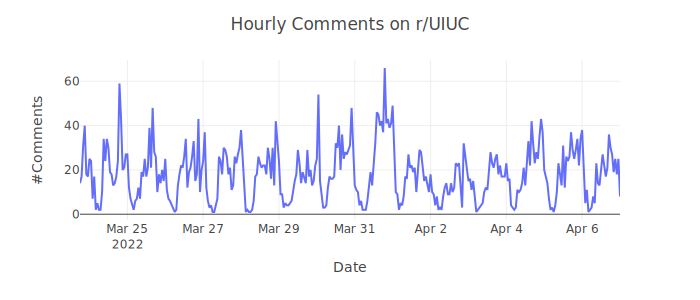

In [76]:
subreddit = 'UIUC'

selected_comments = pd.DataFrame(
    all_comments.find({'subreddit': {'$eq': subreddit}})
)

daily = pd.to_datetime(selected_comments['created_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central') \
    .round('H') \
    .value_counts() \
    .sort_index()

fig = px.line(daily)

fig.update_layout(
    template='none',
    showlegend=False,
    height=300,
    xaxis_title='Date',
    yaxis_title='#Comments',
    title=f'Hourly Comments on r/{subreddit}'
)

fig.show('svg')

---
# r/popular Analysis
<a id="popular"></a>
[Back to Top](#top)

## Grouping r/popular thread IDs, identifying their subreddit, and listing their snapshots (along with snapshot attributes).

Each thread should come with their first timestamp (`min_utc`), last timestamp (`max_utc`), and the number of seconds in between known as the thread's lifespan (`popular_window`) and seconds between the first and last comment (`active_window`).

In [87]:
popular_threads = pd.DataFrame(popular_snapshots.aggregate([
    {'$sort': {'retrieved_utc': 1}},
    {'$group': {'_id': '$id',
                'subreddit': {'$first': '$subreddit'},
                'created_utc': {'$first': '$created_utc'},
                'num_snapshots': {'$sum': 1},
                'max_utc': {'$max': '$retrieved_utc'},
                'min_utc': {'$min': '$retrieved_utc'},
                'snapshots': {'$push': 
                              {'retrieved_utc': '$retrieved_utc',
                               'rank': '$rank',
                               'score': '$score',
                               'upvote_ratio': '$upvote_ratio',
                               'num_comments': '$num_comments'}}}},
    {'$sort': {'num_snapshots': -1}}
], allowDiskUse=True)).rename(columns={'_id': 'id'})

popular_threads['datetime'] = \
    pd.to_datetime(popular_threads['created_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['max_datetime'] = \
    pd.to_datetime(popular_threads['max_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['min_datetime'] = \
    pd.to_datetime(popular_threads['min_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['created_to_popular'] = popular_threads['min_utc'] - popular_threads['created_utc']

popular_threads['popular_window'] = popular_threads['max_utc'] - popular_threads['min_utc']

popular_threads = popular_threads.join(
    all_comments_per_thread[['id', 'active_window']].set_index('id'), on='id'
)

popular_threads

,id,subreddit,created_utc,num_snapshots,max_utc,min_utc,snapshots,datetime,max_datetime,min_datetime,created_to_popular,popular_window,active_window
0,tr0fsi,NintendoSwitch,1.648562e+09,655,1648646498,1648566502,"[{'retrieved_utc': 1648566502, 'rank': 96, 'sc...",2022-03-29 09:01:38-05:00,2022-03-30 08:21:38-05:00,2022-03-29 10:08:22-05:00,4004.0,79996,713507.0
1,tw1l9s,MurderedByWords,1.649078e+09,631,1649160198,1649083099,"[{'retrieved_utc': 1649083099, 'rank': 75, 'sc...",2022-04-04 08:07:43-05:00,2022-04-05 07:03:18-05:00,2022-04-04 09:38:19-05:00,5436.0,77099,223177.0
2,ts6sp1,boxoffice,1.648648e+09,612,1648728513,1648653832,"[{'retrieved_utc': 1648653832, 'rank': 92, 'sc...",2022-03-30 08:45:34-05:00,2022-03-31 07:08:33-05:00,2022-03-30 10:23:52-05:00,5898.0,74681,114652.0
3,too3mu,cringepics,1.648300e+09,609,1648383475,1648309167,"[{'retrieved_utc': 1648309167, 'rank': 99, 'sc...",2022-03-26 08:05:20-05:00,2022-03-27 07:17:55-05:00,2022-03-26 10:39:27-05:00,9247.0,74308,723238.0
4,tsyo27,UpliftingNews,1.648730e+09,605,1648815291,1648740130,"[{'retrieved_utc': 1648740130, 'rank': 95, 'sc...",2022-03-31 07:29:11-05:00,2022-04-01 07:14:51-05:00,2022-03-31 10:22:10-05:00,10379.0,75161,568248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6608,twu043,cats,1.649162e+09,1,1649181124,1649181124,"[{'retrieved_utc': 1649181124, 'rank': 0, 'sco...",2022-04-05 07:39:29-05:00,2022-04-05 12:52:04-05:00,2022-04-05 12:52:04-05:00,18755.0,0,98076.0
6609,twu1oy,BoJackHorseman,1.649163e+09,1,1649176350,1649176350,"[{'retrieved_utc': 1649176350, 'rank': 0, 'sco...",2022-04-05 07:41:51-05:00,2022-04-05 11:32:30-05:00,2022-04-05 11:32:30-05:00,13839.0,0,52423.0
6610,tx012s,Showerthoughts,1.649179e+09,1,1649193246,1649193246,"[{'retrieved_utc': 1649193246, 'rank': 94, 'sc...",2022-04-05 12:19:14-05:00,2022-04-05 16:14:06-05:00,2022-04-05 16:14:06-05:00,14092.0,0,120015.0
6611,tx4hq7,Damnthatsinteresting,1.649191e+09,1,1649199121,1649199121,"[{'retrieved_utc': 1649199121, 'rank': 89, 'sc...",2022-04-05 15:38:04-05:00,2022-04-05 17:52:01-05:00,2022-04-05 17:52:01-05:00,8037.0,0,73867.0


## Aggregating r/popular threads per subreddit to provide descriptive measures.

In [88]:
popular_subreddits = popular_threads.groupby('subreddit') \
    .agg({'popular_window': 'mean',
          'id': 'count',
          'num_snapshots': 'sum',
          'created_to_popular': 'mean',
          'popular_window': 'mean',
          'active_window': 'mean'}) \
    .rename(columns={'id': 'num_threads', 'popular_window': 'average_popular_window'}) \
    .astype(int) \
    .sort_values(by='num_threads', ascending=False)

popular_subreddits

,average_popular_window,num_threads,num_snapshots,created_to_popular,active_window
subreddit,,,,,
worldnews,17112,123,15866,15348,406719
memes,9753,121,9245,11776,288099
interestingasfuck,16400,119,14867,13094,404223
shitposting,11504,116,10422,11635,262126
antiwork,18471,103,14665,14726,376426
...,...,...,...,...,...
houseplants,20413,1,134,56533,1217530
hungary,8063,1,53,27840,120919
PS4,33897,1,273,16930,713104


## For a specific r/popular thread, graph it's rank trajectory.

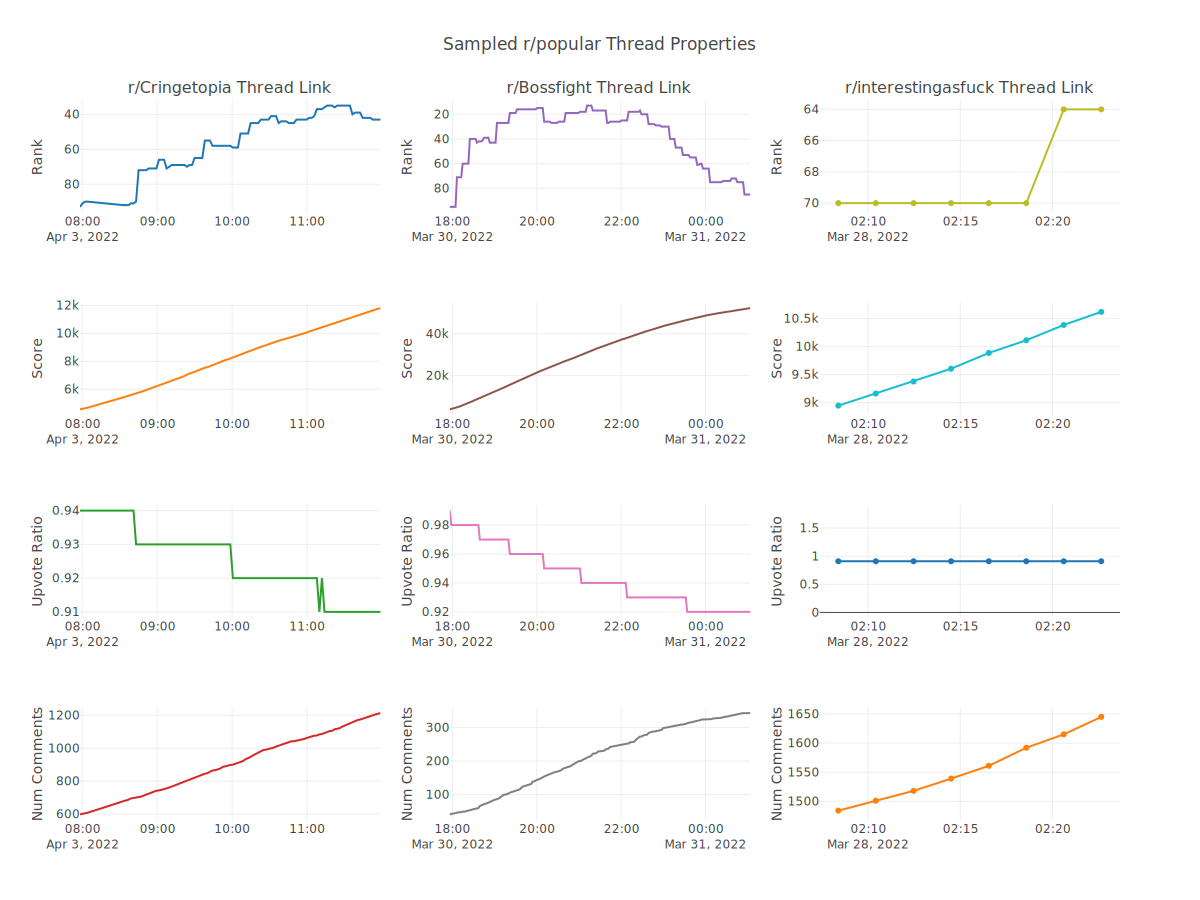

In [89]:
condition = pd.to_datetime(popular_threads['max_utc'], unit='s') \
    < (dt.datetime.now() - dt.timedelta(days=2))

sampled_threads = popular_threads[condition].sample(n=3)
sampled_snapshots = [pd.DataFrame(snapshots) for snapshots in sampled_threads['snapshots']]

titles = [
    f'<a href="https://reddit.com/{thread.id}" target="_blank">r/{thread.subreddit} Thread Link</a>'
    for thread in sampled_threads.itertuples()
]

fig = make_subplots(rows=4, cols=3,
                   subplot_titles=(titles[0], titles[1], titles[2], '',
                                   '', '', '', '',
                                   '', '', '', ''))

for col, snapshots in enumerate(sampled_snapshots):
    
    snapshots['datetime'] = pd.to_datetime(snapshots['retrieved_utc'], unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('US/Central')
    
    for row, column in enumerate(['rank', 'score', 'upvote_ratio', 'num_comments']):
        fig.add_trace(
            go.Scatter(x=snapshots['datetime'], y=snapshots[column]),
            row=row+1, col=col+1
        )
        
        fig.update_yaxes(title=column.replace('_', ' ').title(),
                        row=row+1, col=col+1)
    
    fig.update_yaxes(autorange='reversed', zeroline=False,
                     row=1, col=col+1)
        
fig.update_layout(
    template='none',
    height=900,
    width=1200,
    showlegend=False,
    title=f'Sampled r/popular Thread Properties'
)

fig.show('svg')

## Number of r/popular threads on the feed for a specific subreddit.

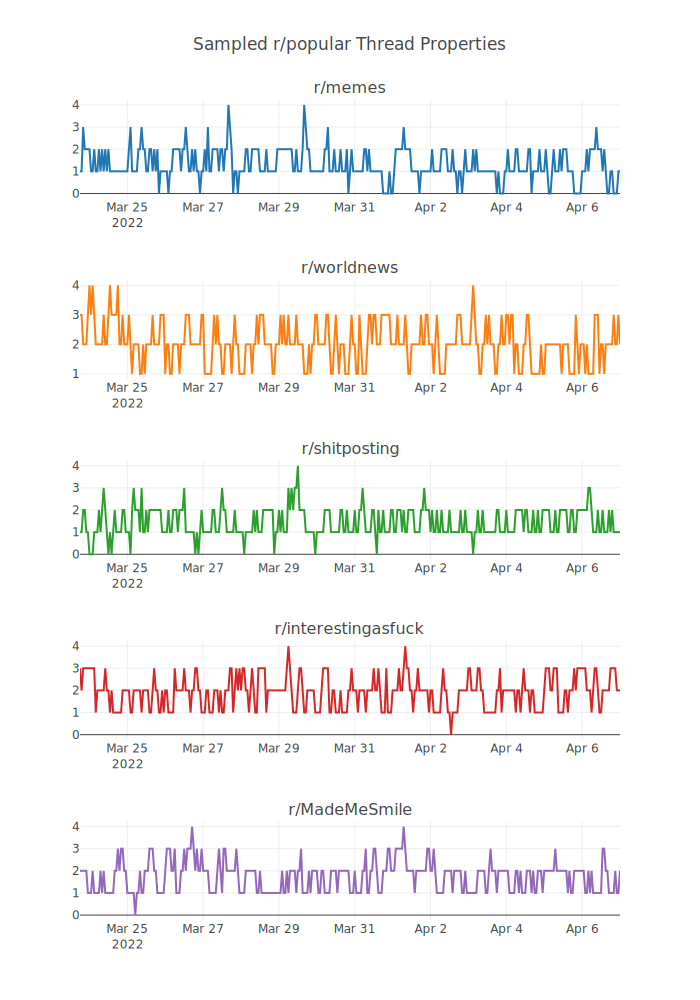

In [90]:
subreddits = ['memes', 'worldnews', 'shitposting', 'interestingasfuck', 'MadeMeSmile']

fig = make_subplots(rows=len(subreddits), subplot_titles=tuple([
    f'<a href="https://reddit.com/r/{subreddit}" target="_blank">r/{subreddit}</a>'
    for subreddit in subreddits
]))

for row, subreddit in enumerate(subreddits):
    
    popular_ranges = popular_threads[popular_threads['subreddit'] == subreddit] \
        [['min_datetime', 'max_datetime']]
    popular_ranges['start_hour'] = popular_ranges['min_datetime'].dt.round('H')
    popular_ranges['end_hour'] = popular_ranges['max_datetime'].dt.round('H')
    
    start = popular_ranges['start_hour'].min()
    end = popular_ranges['end_hour'].max()
    
    date_index = pd.date_range(start, end , freq='H')
    
    count = pd.DataFrame(index=date_index,
                        columns=['num_popular'],
                        data=[0 for _ in range(len(date_index))])
    
    for thread in popular_ranges.itertuples():
        for hour in pd.date_range(thread.start_hour, thread.end_hour, freq='H'):
            count.loc[hour] += 1
            
            
    fig.add_trace(
        go.Scatter(x=count.index, y=count['num_popular']),
        row=row+1, col=1
    )
    
fig.update_layout(
    template='none',
    showlegend=False,
    height=200*len(subreddits),
    title=f'Sampled r/popular Thread Properties'
)
    
fig.show('svg')

## Given that we collected comments from Pushshift (for historical reasons), how many newcomers are there for each r/popular thread?

In [ ]:
def count_newcomers(threads, subreddit):
    
    counts = {}
    
    # Are newcomers who comment for the first time? Or post? Or both?
    # Updating a static dictionary. If it's slow.
    first_comments = pd.DataFrame(
        ps_comments[subreddit].aggregate([
            {'$group': {
                '_id': '$author',
                'first_comment': {
                    '$min': {
                        'created_utc': '$created_utc',
                        'author': '$author',
                        'id': '$id',
                        'permalink': '$permalink'
                    }
                }
            }},
            {'$replaceRoot': {'newRoot': '$first_comment'}}
        ], allowDiskUse=True)
    )
    
    first_comment_ids = set(first_comments['id'])
    
    for id in threads['id']:
        thread_comments = pd.DataFrame(
            ps_comments[subreddit].find({'link_id': {'$eq': 't3_' + id}})
        )
        
        comment_ids = set(thread_comments['id'])
        
        new_comment_ids = comment_ids.intersection(first_comment_ids)
        
        counts[id] = {
            'num_newcomers': len(new_comment_ids),
            'new_comments': list(new_comment_ids),
            'num_comments': len(comment_ids),
            '%new_comments': len(new_comment_ids) / len(comment_ids)
        }
                
    
    return pd.DataFrame.from_dict(counts, orient='index')

subreddit = 'lotrmemes'

selected_threads = popular_threads[popular_threads['subreddit'] == subreddit].copy()

selected_threads = selected_threads.join(
    count_newcomers(selected_threads, subreddit),
    on='id'
)

# Total unique authors. How many authors are newcomers within the thread.
# Dealing with newcomers as users, not comments. 
# --- unique autors, new authors, total comments, newcomer comments. ---
# Optimize to run on all threads to compare.
# Retention of those newcomers, when does 95% of them stop particpating within the community.

selected_threads[['id', 'num_comments', 'num_newcomers', '%new_comments']].round(2)

# Pushshift Analysis
<a id="pushshift"></a>
[Back to Top](#top)

## Comparing data collected from Reddit (PRAW) and Pushshift (PSAW).

In [ ]:
subreddit = 'PeopleFuckingDying'

praw = pd.DataFrame(
    all_comments.find({'subreddit': {'$eq': subreddit}})
)

praw_hourly = count_hourly(praw['created_utc'], tz='UTC')

psaw_comments = pd.DataFrame(
    ps_comments[subreddit].find({})
)

psaw_comments_hourly = count_hourly(psaw_comments['created_utc'], tz='UTC')
psaw_comments_monthly = count_monthly(psaw_comments['created_utc'])

psaw_threads = pd.DataFrame(
    ps_threads[subreddit].find({})
)

psaw_threads_monthly = count_monthly(psaw_threads['created_utc'])

# Graphing code.
fig = make_subplots(rows=3, subplot_titles=('Reddit vs. Pushshift Comments', 'Pushshift Comments', 'Pushshift Threads'))

fig.add_trace(
    go.Scatter(
        x=praw_hourly.index,
        y=praw_hourly.values,
        name='Reddit'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=psaw_comments_hourly[praw_hourly.index[0]:praw_hourly.index[-1]].index,
        y=psaw_comments_hourly[praw_hourly.index[0]:praw_hourly.index[-1]].values,
        name='Pushshift'
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=psaw_comments_monthly.index,
        y=psaw_comments_monthly.values,
        showlegend=False
    ), row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=psaw_threads_monthly.index,
        y=psaw_threads_monthly.values,
        showlegend=False
    ), row=3, col=1
)

fig.update_layout(
    template='none',
    title=f'Comparing PRAW and PSAW Collection for ' \
        f'<a href="https://reddit.com/r/{subreddit}" target="_blank">r/{subreddit}</a>'
)
    
fig.show('svg')

# Comparing comment reliability.
time_window = (psaw['created_utc'] >= praw['created_utc'].min()) & \
    (psaw['created_utc'] <= praw['created_utc'].max())

psaw_ids = set(psaw_comments[time_window]['id'])

praw_ids = set(praw['id'])

all_ids = psaw_ids.union(praw_ids)

display(pd.DataFrame.from_dict({
    'PSAW Comments': {
        'N': len(psaw_ids), '%': len(psaw_ids) / len(all_ids)
    },
    'PRAW Comments': {
        'N': len(praw_ids), '%': len(praw_ids) / len(all_ids)
    },
    'Both': {
        'N': len(all_ids), '%': len(all_ids) / len(all_ids)
    }
}, orient='index'))